In [1]:
from collections import Counter
import numpy as np
import pandas as pd
import Levenshtein  # pip install python-Levenshtein
import re

In [2]:
import pandas as pd

# Show all columns
pd.set_option('display.max_columns', None)

# Show all rows
pd.set_option('display.max_rows', None)

# Prevent truncating column content
pd.set_option('display.max_colwidth', None)  # For pandas < 1.0 use -1 instead of None


In [109]:
data = pd.read_csv('df_f_1.csv')

In [4]:
df=data.copy()

In [5]:
# Replace values that are: nan/NA/unknown (case-insensitive) or only whitespace
df = df.applymap(
    lambda x: np.nan if isinstance(x, str) and x.strip().lower() in ['nan', 'na', 'unknown', ''] else x
)


/var/folders/0z/nh4zphkd0ljgxbl85xr8nlp00000gn/T/ipykernel_47376/1795654457.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(


In [ ]:
#df[df['NATIONALITY_NAME'] == 'Saudi Arabia']['NATIONALITY_CD'] = 'SAU'

In [6]:
# Clean NATIONALITY_CD
df['NATIONALITY_CD'] = df['NATIONALITY_CD'].apply(
    lambda x: x.strip().upper() if isinstance(x, str) else x
)

# Clean NATIONALITY_NAME
df['NATIONALITY_NAME'] = df['NATIONALITY_NAME'].apply(
    lambda x: x.strip().title() if isinstance(x, str) else x
)

# Clean SAUDI_NON_SAUDI
df['SAUDI_NON_SAUDI'] = df['SAUDI_NON_SAUDI'].apply(
    lambda x: x.strip().title() if isinstance(x, str) else x
)


In [7]:
df['SAUDI_NON_SAUDI'] = np.where(
    (df['NATIONALITY_CD'] == 'SAU') | (df['NATIONALITY_NAME'] == 'Saudi Arabia'),
    'Saudi',
    df['SAUDI_NON_SAUDI']
)

In [8]:
df['NATIONALITY_CD'] = np.where(
    (df['SAUDI_NON_SAUDI'] == 'Saudi') | (df['NATIONALITY_NAME'] == 'Saudi Arabia'),
    'SAU',
    df['NATIONALITY_CD']
)


In [9]:
df['NATIONALITY_NAME'] = np.where(
    (df['SAUDI_NON_SAUDI'] == 'Saudi') | (df['NATIONALITY_CD'] == 'SAU'),
    'Saudi Arabia',
    df['NATIONALITY_NAME']
)


In [11]:
# Define the flag columns
flag_cols = ['_2G_FLG', '_3G_FLG', '_4G_FLG', 'WIFI_FLG', 'BLUETOOTH_FLG', 'TOUCH_SCREEN_FLG', 'DUAL_SIM_FLG']

# Standardize the flag values
for col in flag_cols:
    df[col] = df[col].astype(str).str.strip().str.lower().map({
        'y': 'Y', 'yes': 'Y',
        'n': 'N', 'no': 'N'
    }).fillna(df[col])  # leave other values unchanged


In [12]:
df['DEVICE_COUNT'] = df['DEVICE_COUNT'].replace('ten', 10)


In [13]:

# Define a function to clean text: strip + normalize inner spaces
def clean_text(val):
    if isinstance(val, str):
        return re.sub(r'\s+', ' ', val.strip())
    return val

# Apply to all columns (only string values will be affected)
df = df.applymap(clean_text)


/var/folders/0z/nh4zphkd0ljgxbl85xr8nlp00000gn/T/ipykernel_47376/1421895304.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(clean_text)


In [14]:
cols_to_lower = ['MODEL_NAME', 'BRAND_FULL_NAME', 'BRAND_NAME', 'VENDOR_NAME', 'OS_NAME', 'DEVICE_TYPE']

for col in cols_to_lower:
    df[col] = df[col].apply(lambda x: x.lower() if isinstance(x, str) else x)


In [15]:
def fix_brand_name(row):
    brand_name = row['BRAND_NAME']
    full_name = row['BRAND_FULL_NAME']
    
    if isinstance(full_name, str):
        first_word = full_name.strip().split()[0].lower()  # first word in full name

        if (not isinstance(brand_name, str)) or (brand_name.strip().lower() != first_word):
            return first_word

    return brand_name

# Apply the rule
df['BRAND_NAME'] = df.apply(fix_brand_name, axis=1)


In [16]:
# Columns to clean
cols_to_clean = ['MODEL_NAME', 'BRAND_FULL_NAME', 'BRAND_NAME', 'VENDOR_NAME', 'OS_NAME', 'DEVICE_TYPE']

for col in cols_to_clean:
    df[col] = df[col].astype(str).str.replace(' | ', '', regex=False)


for col in cols_to_clean:
    df[col] = df[col].astype(str).str.replace(' |', '', regex=False)


for col in cols_to_clean:
    df[col] = df[col].astype(str).str.replace('|', '', regex=False)


# Step 1: Remove unwanted characters (except parentheses)
symbol_pattern = r"[!@#$%^&*_={};:'\"<>,.?/\\|`~]"  # Adjusted to include more symbols

# Step 2: Remove unmatched ( or )
def remove_unmatched_parens(text):
    if not isinstance(text, str):
        return text

    # Count opening and closing
    open_count = text.count('(')
    close_count = text.count(')')

    # If unmatched '(', remove it
    if open_count > close_count:
        text = text.replace('(', '')
    # If unmatched ')', remove it
    if close_count > open_count:
        text = text.replace(')', '')

    return text

# Apply both cleaning steps
for col in cols_to_clean:
    df[col] = df[col].apply(lambda x: re.sub(symbol_pattern, '', x) if isinstance(x, str) else x)
    df[col] = df[col].apply(remove_unmatched_parens)


In [17]:
df = df.applymap(
    lambda x: np.nan if isinstance(x, str) and x.strip().lower() in ['nan', 'na', 'unknown', ''] else x
)

/var/folders/0z/nh4zphkd0ljgxbl85xr8nlp00000gn/T/ipykernel_47376/2280587693.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(


In [116]:
# Cleaning function: remove '+' only if not at the end
def clean_plus(text):
    if isinstance(text, str):
        return re.sub(r'\+(?=\w)', '', text)
    return text

# Apply the function to each column
for col in cols_to_lower:
    df[col] = df[col].apply(clean_plus)

# Take first of full name to model name

In [20]:
def fill_model_from_brand_full(row):
    if pd.isna(row['MODEL_NAME']) and pd.notna(row['BRAND_FULL_NAME']):
        parts = row['BRAND_FULL_NAME'].strip().split()
        if len(parts) > 1:
            return ' '.join(parts[1:])  # Everything except the first word
        else:
            return ''  # Only one word in BRAND_FULL_NAME
    return row['MODEL_NAME']  # Keep original

df['MODEL_NAME'] = df.apply(fill_model_from_brand_full, axis=1)


# Full name = ( Brand Name + Model Name )

In [21]:
mask = df['BRAND_FULL_NAME'].isna() & df['BRAND_NAME'].notna() & df['MODEL_NAME'].notna()

df.loc[mask, 'BRAND_FULL_NAME'] = (
    df.loc[mask, 'BRAND_NAME'].str.strip() + ' ' + df.loc[mask, 'MODEL_NAME'].str.strip()
)


# Correct Names

In [ ]:
import pandas as pd
from collections import Counter
import Levenshtein

def correct_similar_values(df, column, max_distance=2):
    print(f"Cleaning column: '{column}'")

    # Step 1: Drop NaNs and prepare the value list
    values = df[column].dropna().astype(str).str.strip()
    frequencies = Counter(values)
    unique_values = list(frequencies.keys())
    visited = set()
    corrections = {}

    # Step 2: Compare all pairs to find similar groups
    for i, val1 in enumerate(unique_values):
        if val1 in visited:
            continue
        group = [val1]
        for val2 in unique_values[i+1:]:
            if val2 in visited:
                continue
            if Levenshtein.distance(val1.lower(), val2.lower()) <= max_distance:
                group.append(val2)
                visited.add(val2)
        visited.add(val1)

        # Pick the most frequent value in the group
        if len(group) > 1:
            canonical = max(group, key=lambda x: frequencies[x])
            for val in group:
                if val != canonical:
                    corrections[val] = canonical

    # Step 3: Apply corrections
    df_cleaned = df.copy()
    df_cleaned[column] = df_cleaned[column].apply(lambda x: corrections.get(x, x) if isinstance(x, str) else x)

    print(f"Unique values reduced: {df[column].nunique()} → {df_cleaned[column].nunique()}")
    return df_cleaned, corrections


In [23]:
columns_to_fix = ['NATIONALITY_NAME', 'SAUDI_NON_SAUDI', 'VENDOR_NAME', 'OS_NAME', 'DEVICE_TYPE']

for col in columns_to_fix:
    df, fixes = correct_similar_values(df, column=col)


Cleaning column: 'NATIONALITY_NAME'
Unique values reduced: 1558 → 206
Cleaning column: 'SAUDI_NON_SAUDI'
Unique values reduced: 2 → 2
Cleaning column: 'VENDOR_NAME'
Unique values reduced: 845 → 107
Cleaning column: 'OS_NAME'
Unique values reduced: 201 → 9
Cleaning column: 'DEVICE_TYPE'
Unique values reduced: 2 → 2


In [36]:
# Fix the logic to correctly replace 'uyknown' with 'unknown' in OS_NAME
df.loc[df['OS_NAME'] == 'uyknown', 'OS_NAME'] = 'unknown'

In [37]:
df.OS_NAME.value_counts()

OS_NAME
android           108906
proprietary        64263
symbian             6445
other               4618
rim os              1986
windows phone       1815
blackberry os        962
unknown               37
windows mobile        34
Name: count, dtype: int64

In [38]:
# Replace values that are: nan/NA/unknown (case-insensitive) or only whitespace
df = df.applymap(
    lambda x: np.nan if isinstance(x, str) and x.strip().lower() in ['nan', 'na', 'unknown', ''] else x
)


/var/folders/0z/nh4zphkd0ljgxbl85xr8nlp00000gn/T/ipykernel_47376/1795654457.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(


In [39]:
df.OS_NAME.value_counts()

OS_NAME
android           108906
proprietary        64263
symbian             6445
other               4618
rim os              1986
windows phone       1815
blackberry os        962
windows mobile        34
Name: count, dtype: int64

In [34]:
df.head()

,CAL_DT,MODEL_NAME,BRAND_FULL_NAME,BRAND_NAME,VENDOR_NAME,OS_NAME,DEVICE_TYPE,_2G_FLG,_3G_FLG,_4G_FLG,WIFI_FLG,BLUETOOTH_FLG,TOUCH_SCREEN_FLG,DUAL_SIM_FLG,GENDER_TYPE_CD,AGE_B,NATIONALITY_CD,NATIONALITY_NAME,SAUDI_NON_SAUDI,DEVICE_COUNT
0,7/31/2019,1x dual sim,alcatel 1x dual sim,alcatel,google,android,smartphone,Y,Y,Y,Y,Y,Y,Y,Female,26-35,NaN,NaN,Non-Saudi,4
1,3/31/2019,k7 dual sim,lg k7 dual sim,lg,google,android,smartphone,Y,Y,N,Y,Y,Y,Y,Female,18-25,JOR,Jordan,Non-Saudi,1
2,11/30/2019,eluga i3,panasonic eluga i3,panasonic,google,android,smartphone,Y,Y,N,Y,Y,Y,Y,Female,>55,ZAF,South Africa,Non-Saudi,1
3,8/31/2019,m98,hedy m98,hedy,hedy,proprietary,mobile phone,Y,N,N,N,NaN,N,N,Female,36-55,YEM,Yemen,Non-Saudi,3
4,12/31/2019,105,nokia 105,nokia,nokia,proprietary,mobile phone,Y,N,N,N,N,NaN,N,Male,NaN,IND,India,Non-Saudi,3758


# Outliers

In [35]:
df.DEVICE_COUNT.value_counts()

DEVICE_COUNT
1        78002
2        26887
3        14272
4         9138
5         6493
6         4916
7         4012
8         3157
9         2683
10        2301
11        1997
64521     1869
12        1710
13        1511
14        1347
15        1200
31        1139
16        1066
17         983
10         971
18         893
19         852
20         739
21         656
32         640
22         631
23         617
24         604
25         536
26         530
33         487
27         483
28         460
34         454
29         445
35         391
30         369
36         332
39         330
37         324
40         315
42         288
38         288
41         257
43         253
44         248
45         212
49         209
46         203
51         177
48         177
52         174
50         173
47         167
53         162
58         156
54         156
56         137
57         133
55         131
61         127
63         126
64         119
62         119
60         119
70         1

In [36]:
data['DEVICE_COUNT'].isna().sum()

np.int64(12052)

In [40]:
# Convert DEVICE_COUNT to integer (nullable Int64 to handle NaNs)
df['DEVICE_COUNT'] = pd.to_numeric(df['DEVICE_COUNT'], errors='coerce').astype('Int64')

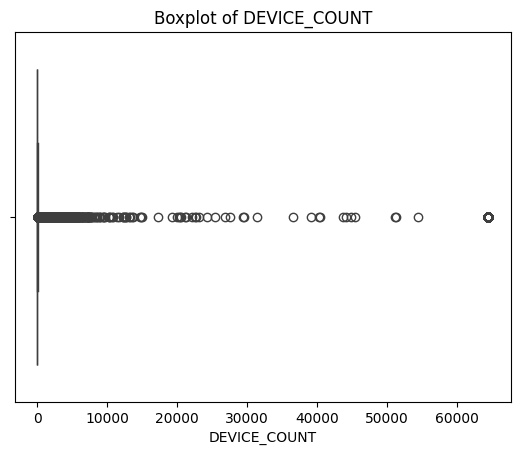

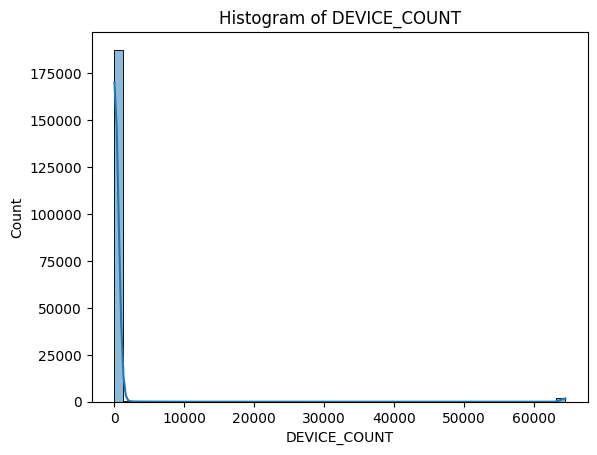

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(x=df['DEVICE_COUNT'])
plt.title("Boxplot of DEVICE_COUNT")
plt.show()

sns.histplot(df['DEVICE_COUNT'], bins=50, kde=True)
plt.title("Histogram of DEVICE_COUNT")
plt.show()


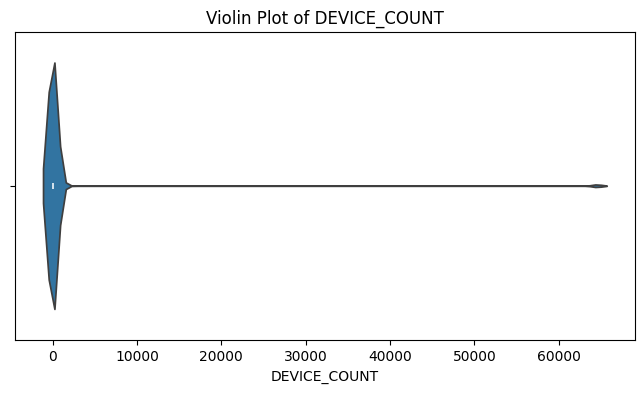

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.violinplot(x=df['DEVICE_COUNT'])
plt.title("Violin Plot of DEVICE_COUNT")
plt.xlabel("DEVICE_COUNT")
plt.show()

In [41]:
Q1 = df['DEVICE_COUNT'].quantile(0.25)
Q3 = df['DEVICE_COUNT'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['DEVICE_COUNT'] < lower_bound) | (df['DEVICE_COUNT'] > upper_bound)]
print(f"Outliers found: {len(outliers)}")


Outliers found: 28285


In [43]:
df.OS_NAME.value_counts()

OS_NAME
android           108906
proprietary        64263
symbian             6445
other               4618
rim os              1986
windows phone       1815
blackberry os        962
windows mobile        34
Name: count, dtype: int64

In [44]:
df.DEVICE_TYPE.value_counts()

DEVICE_TYPE
smartphone      121340
mobile phone     68569
Name: count, dtype: int64

In [45]:
df.SAUDI_NON_SAUDI.value_counts()

SAUDI_NON_SAUDI
Non-Saudi    180880
Saudi         21120
Name: count, dtype: int64

In [46]:
device_col = df['DEVICE_COUNT']

# 1. Define thresholds
low = device_col.quantile(0.01)
high = device_col.quantile(0.99)

# 2. Masks
normal_mask = (device_col >= low) & (device_col <= high)
outlier_mask = ~normal_mask

# 3. Normal range values
normal_values = device_col[normal_mask]

# 4. Outlier range values
outlier_values = device_col[outlier_mask]

# 5. Rescale outliers linearly into [low, high]
out_min = outlier_values.min()
out_max = outlier_values.max()

def rescale_value(x, old_min, old_max, new_min, new_max):
    return new_min + (x - old_min) * (new_max - new_min) / (old_max - old_min)

rescaled_outliers = outlier_values.apply(
    lambda x: rescale_value(x, out_min, out_max, low, high)
)

# 6. Create new column combining normal + rescaled outliers
df['DEVICE_COUNT_SCALED'] = device_col.copy()  # keep original dtype (int)

# Round and convert scaled outliers to int before assigning
df.loc[outlier_mask, 'DEVICE_COUNT_SCALED'] = rescaled_outliers.round().astype(int)

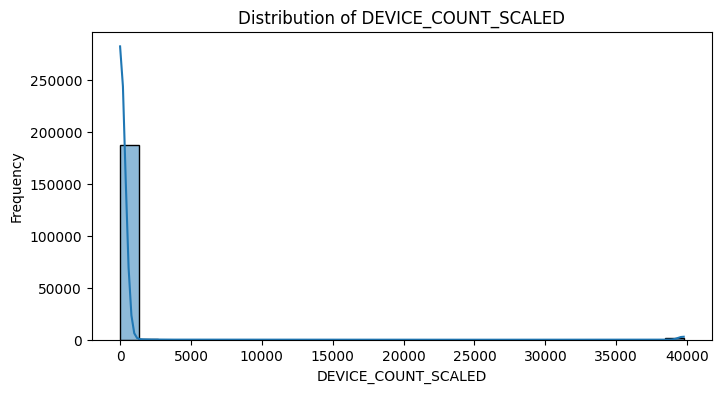

DEVICE_COUNT_SCALED
1        78003
2        26887
3        14272
4         9138
5         6493
6         4916
7         4012
8         3157
9         2683
10        3272
11        1997
12        1710
13        1511
14        1347
15        1200
16        1066
17         983
18         893
19         852
20         739
21         656
22         631
23         617
24         604
25         536
26         530
27         483
28         460
29         445
30         369
31        1139
32         640
33         487
34         454
35         391
36         332
37         324
38         288
39         330
40         315
41         257
42         288
43         253
44         248
45         212
46         203
47         167
48         177
49         209
50         173
51         177
52         174
53         162
54         156
55         131
56         137
57         133
58         156
59         114
60         119
61         127
62         119
63         126
64         119
65         109
66   

In [47]:
# Distribution of DEVICE_COUNT_SCALED
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(df['DEVICE_COUNT_SCALED'].dropna(), bins=30, kde=True)
plt.title("Distribution of DEVICE_COUNT_SCALED")
plt.xlabel("DEVICE_COUNT_SCALED")
plt.ylabel("Frequency")
plt.show()

# Show value counts as well
print(df['DEVICE_COUNT_SCALED'].value_counts().sort_index())

In [51]:
def replace_outliers_with_scaled_safe(data, outlier_method='iqr'):
    """
    Apply RobustScaler with data cleaning and outlier replacement
    """
    # Clean data first
    clean_data = pd.to_numeric(data, errors='coerce')
    
    # Remove NaN values for processing
    valid_mask = clean_data.notna()
    valid_data = clean_data[valid_mask]
    
    if len(valid_data) == 0:
        return data.copy(), pd.Series(False, index=data.index)
    
    # Step 1: Identify outliers
    if outlier_method == 'iqr':
        Q1 = valid_data.quantile(0.25)
        Q3 = valid_data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_mask = (valid_data < lower_bound) | (valid_data > upper_bound)
    
    elif outlier_method == 'zscore':
        z_scores = np.abs((valid_data - valid_data.mean()) / valid_data.std())
        outlier_mask = z_scores > 3
    
    # Step 2: Apply RobustScaler to valid data
    scaler = RobustScaler()
    scaled_data = scaler.fit_transform(valid_data.values.reshape(-1, 1)).flatten()
    
    # Step 3: Create result
    result = clean_data.copy()
    result[valid_mask] = valid_data  # Keep original non-outliers
    result[valid_mask & outlier_mask] = scaled_data[outlier_mask]  # Replace outliers
    
    return result, outlier_mask

# Usage
df['DEVICE_COUNT_processed'], outliers_mask = replace_outliers_with_scaled_safe(df['DEVICE_COUNT'])

In [52]:
# Now this should work
print("Outliers before and after:")
threshold = df['DEVICE_COUNT_processed'].quantile(0.95)
outliers_mask = (df['DEVICE_COUNT_processed'] > threshold)

comparison = pd.DataFrame({
    'Original': df['DEVICE_COUNT'].head(10),
    'Processed': df['DEVICE_COUNT_processed'].head(10)
})
print(comparison)

Outliers before and after:
  Original  Processed
0        4        4.0
1        1        1.0
2        1        1.0
3        3        3.0
4     3758      626.0
5        1        1.0
6        1        1.0
7        1        1.0
8       14       14.0
9        5        5.0


In [56]:
df.drop(columns=['DEVICE_COUNT_scaled', 'zscore', 'DEVICE_COUNT_SCALED'], inplace=True)

# Fill null

In [57]:
df.head()

,CAL_DT,MODEL_NAME,BRAND_FULL_NAME,BRAND_NAME,VENDOR_NAME,OS_NAME,DEVICE_TYPE,_2G_FLG,_3G_FLG,_4G_FLG,WIFI_FLG,BLUETOOTH_FLG,TOUCH_SCREEN_FLG,DUAL_SIM_FLG,GENDER_TYPE_CD,AGE_B,NATIONALITY_CD,NATIONALITY_NAME,SAUDI_NON_SAUDI,DEVICE_COUNT,False,DEVICE_COUNT_processed
0,7/31/2019,1x dual sim,alcatel 1x dual sim,alcatel,google,android,smartphone,Y,Y,Y,Y,Y,Y,Y,Female,26-35,NaN,NaN,Non-Saudi,4,NaN,4.0
1,3/31/2019,k7 dual sim,lg k7 dual sim,lg,google,android,smartphone,Y,Y,N,Y,Y,Y,Y,Female,18-25,JOR,Jordan,Non-Saudi,1,NaN,1.0
2,11/30/2019,eluga i3,panasonic eluga i3,panasonic,google,android,smartphone,Y,Y,N,Y,Y,Y,Y,Female,>55,ZAF,South Africa,Non-Saudi,1,NaN,1.0
3,8/31/2019,m98,hedy m98,hedy,hedy,proprietary,mobile phone,Y,N,N,N,NaN,N,N,Female,36-55,YEM,Yemen,Non-Saudi,3,NaN,3.0
4,12/31/2019,105,nokia 105,nokia,nokia,proprietary,mobile phone,Y,N,N,N,N,NaN,N,Male,NaN,IND,India,Non-Saudi,3758,NaN,626.0


In [59]:
df.isna().sum()

CAL_DT                     12035
MODEL_NAME                   725
BRAND_FULL_NAME             1394
BRAND_NAME                   703
VENDOR_NAME                12933
OS_NAME                    12971
DEVICE_TYPE                12091
_2G_FLG                    12065
_3G_FLG                    12061
_4G_FLG                    12073
WIFI_FLG                   12054
BLUETOOTH_FLG              12032
TOUCH_SCREEN_FLG           12055
DUAL_SIM_FLG               12045
GENDER_TYPE_CD             34642
AGE_B                      41312
NATIONALITY_CD             22099
NATIONALITY_NAME           22056
SAUDI_NON_SAUDI                0
DEVICE_COUNT               12052
False                     202000
DEVICE_COUNT_processed     13023
dtype: int64

In [81]:
df.DEVICE_TYPE.value_counts()

DEVICE_TYPE
smartphone      121340
mobile phone     68569
Name: count, dtype: int64

In [82]:
df.DEVICE_TYPE.isna().sum()

np.int64(12091)

In [72]:
df.OS_NAME.value_counts()

OS_NAME
android           108906
proprietary        64263
symbian             6445
other               4618
rim os              1986
windows phone       1815
blackberry os        962
windows mobile        34
Name: count, dtype: int64

In [60]:
# If BRAND_NAME is null and BRAND_FULL_NAME is not null, fill BRAND_NAME with the first word of BRAND_FULL_NAME
mask = df['BRAND_NAME'].isna() & df['BRAND_FULL_NAME'].notna()
df.loc[mask, 'BRAND_NAME'] = df.loc[mask, 'BRAND_FULL_NAME'].str.strip().str.split().str[0]

In [61]:
# If MODEL_NAME is null and BRAND_FULL_NAME is not null, fill MODEL_NAME with everything except the first word in BRAND_FULL_NAME
mask = df['MODEL_NAME'].isna() & df['BRAND_FULL_NAME'].notna()
df.loc[mask, 'MODEL_NAME'] = df.loc[mask, 'BRAND_FULL_NAME'].str.strip().str.split().str[1:].str.join(' ')

In [62]:
# If BRAND_FULL_NAME is null and both MODEL_NAME and BRAND_NAME are not null, fill BRAND_FULL_NAME with "BRAND_NAME + MODEL_NAME"
mask = df['BRAND_FULL_NAME'].isna() & df['BRAND_NAME'].notna() & df['MODEL_NAME'].notna()
df.loc[mask, 'BRAND_FULL_NAME'] = (
    df.loc[mask, 'BRAND_NAME'].str.strip() + ' ' + df.loc[mask, 'MODEL_NAME'].str.strip()
)

In [86]:
df.BRAND_NAME.value_counts()

BRAND_NAME
nokia               63549
lenovo              13101
htc                 12546
lg                  11487
sony                11007
xiaomi              10394
alcatel              9355
oppo                 6330
vivo                 5263
lava                 5106
tecno                4865
motorola             4724
panasonic            4309
oneplus              3034
four                 2918
infinix              2819
rim                  2091
itel                 1944
mione                1915
asus                 1712
symphony             1688
philips              1624
blackberry           1591
microsoft            1123
micromax             1027
bocoin               1025
innjoo               1018
darago                753
google                671
star                  584
qmobile               556
eurostar              498
realme                440
xtouch                427
blu                   408
hope                  350
fero                  347
energizer             327
w

In [88]:
# Correct way to filter rows where OS_NAME is 'android'
df[(df['OS_NAME'] == 'other') & (True)].DEVICE_TYPE.value_counts()

DEVICE_TYPE
mobile phone    3814
smartphone       522
Name: count, dtype: int64

In [91]:
# Step 1: Define a function to fill nulls with the group's most common DEVICE_TYPE
def fill_device_type(group):
    if group['DEVICE_TYPE'].isnull().any():
        mode = group['DEVICE_TYPE'].mode()
        if not mode.empty:
            group['DEVICE_TYPE'] = group['DEVICE_TYPE'].fillna(mode.iloc[0])
    return group

# Step 2: Apply the function on each group
df = df.groupby(['OS_NAME', 'VENDOR_NAME'], group_keys=False).apply(fill_device_type)


/var/folders/0z/nh4zphkd0ljgxbl85xr8nlp00000gn/T/ipykernel_47376/2921488375.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['OS_NAME', 'VENDOR_NAME'], group_keys=False).apply(fill_device_type)


In [92]:
df['DEVICE_TYPE'].value_counts()

DEVICE_TYPE
smartphone      113288
mobile phone     64451
Name: count, dtype: int64

In [93]:
df.DEVICE_TYPE.isna().sum()

np.int64(1)

In [89]:
df.BRAND_NAME.value_counts()

BRAND_NAME
nokia               63549
lenovo              13101
htc                 12546
lg                  11487
sony                11007
xiaomi              10394
alcatel              9355
oppo                 6330
vivo                 5263
lava                 5106
tecno                4865
motorola             4724
panasonic            4309
oneplus              3034
four                 2918
infinix              2819
rim                  2091
itel                 1944
mione                1915
asus                 1712
symphony             1688
philips              1624
blackberry           1591
microsoft            1123
micromax             1027
bocoin               1025
innjoo               1018
darago                753
google                671
star                  584
qmobile               556
eurostar              498
realme                440
xtouch                427
blu                   408
hope                  350
fero                  347
energizer             327
w

In [94]:
df.head(60)

,CAL_DT,MODEL_NAME,BRAND_FULL_NAME,BRAND_NAME,VENDOR_NAME,OS_NAME,DEVICE_TYPE,_2G_FLG,_3G_FLG,_4G_FLG,WIFI_FLG,BLUETOOTH_FLG,TOUCH_SCREEN_FLG,DUAL_SIM_FLG,GENDER_TYPE_CD,AGE_B,NATIONALITY_CD,NATIONALITY_NAME,SAUDI_NON_SAUDI,DEVICE_COUNT,False,DEVICE_COUNT_processed
0,7/31/2019,1x dual sim,alcatel 1x dual sim,alcatel,google,android,smartphone,Y,Y,Y,Y,Y,Y,Y,Female,26-35,NaN,NaN,Non-Saudi,4,NaN,4.000000
1,3/31/2019,k7 dual sim,lg k7 dual sim,lg,google,android,smartphone,Y,Y,N,Y,Y,Y,Y,Female,18-25,JOR,Jordan,Non-Saudi,1,NaN,1.000000
2,11/30/2019,eluga i3,panasonic eluga i3,panasonic,google,android,smartphone,Y,Y,N,Y,Y,Y,Y,Female,>55,ZAF,South Africa,Non-Saudi,1,NaN,1.000000
3,8/31/2019,m98,hedy m98,hedy,hedy,proprietary,mobile phone,Y,N,N,N,NaN,N,N,Female,36-55,YEM,Yemen,Non-Saudi,3,NaN,3.000000
4,12/31/2019,105,nokia 105,nokia,nokia,proprietary,mobile phone,Y,N,N,N,N,NaN,N,Male,NaN,IND,India,Non-Saudi,3758,NaN,626.000000
5,1/31/2020,one touch 1050 dual sim,alcatel one touch 1050 dual sim,alcatel,alcatel,proprietary,mobile phone,Y,N,N,N,N,N,Y,Male,36-55,BHR,Bahrain,Non-Saudi,1,NaN,1.000000
6,NaN,moto m dual sim,motorola moto m dual sim,motorola,google,android,smartphone,Y,Y,Y,Y,Y,Y,Y,Female,>55,SYR,Syria,Non-Saudi,1,NaN,1.000000
7,2/29/2020,k802,kaliho k802,kaliho,google,android,smartphone,Y,Y,N,NaN,Y,Y,Y,Male,18-25,IDN,Indonesia,Non-Saudi,1,NaN,1.000000
9,12/31/2019,2310,nokia 2310,nokia,nokia,proprietary,mobile phone,Y,N,N,N,N,N,N,Female,36-55,PHL,Philippines,Non-Saudi,5,NaN,5.000000
10,5/31/2019,u5,alcatel u5,alcatel,google,android,smartphone,Y,Y,Y,Y,Y,Y,Y,Female,>55,TCD,Chad,Non-Saudi,1,NaN,1.000000


In [101]:
df[df['BRAND_NAME'] == 'nokia'].head(10)

,CAL_DT,MODEL_NAME,BRAND_FULL_NAME,BRAND_NAME,VENDOR_NAME,OS_NAME,DEVICE_TYPE,_2G_FLG,_3G_FLG,_4G_FLG,WIFI_FLG,BLUETOOTH_FLG,TOUCH_SCREEN_FLG,DUAL_SIM_FLG,GENDER_TYPE_CD,AGE_B,NATIONALITY_CD,NATIONALITY_NAME,SAUDI_NON_SAUDI,DEVICE_COUNT,False,DEVICE_COUNT_processed
4,12/31/2019,105,nokia 105,nokia,nokia,proprietary,mobile phone,Y,N,N,N,N,NaN,N,Male,NaN,IND,India,Non-Saudi,3758,NaN,626.000000
9,12/31/2019,2310,nokia 2310,nokia,nokia,proprietary,mobile phone,Y,N,N,N,N,N,N,Female,36-55,PHL,Philippines,Non-Saudi,5,NaN,5.000000
13,9/30/2020,2680 slide,nokia 2680 slide,nokia,nokia,proprietary,mobile phone,Y,N,N,N,Y,N,N,Male,<18,SYR,Syria,Non-Saudi,1,NaN,1.000000
26,3/31/2020,e71,nokia e71,nokia,symbian ltd,symbian,smartphone,Y,Y,N,Y,Y,N,N,Male,26-35,PHL,Philippines,Non-Saudi,3,NaN,3.000000
29,4/30/2020,301 dual sim,nokia 301 dual sim,nokia,nokia,proprietary,mobile phone,Y,Y,N,N,Y,N,Y,Male,>55,ERI,Eritrea,Non-Saudi,11,NaN,11.000000
30,6/30/2019,2600 classic,nokia 2600 classic,nokia,nokia,proprietary,mobile phone,Y,N,N,N,Y,N,N,Male,>55,LBY,Libya,Non-Saudi,1,NaN,1.000000
37,4/30/2019,c2-03,nokia c2-03,nokia,nokia,proprietary,mobile phone,Y,N,N,N,Y,Y,NaN,NaN,NaN,EGY,Egypt,Non-Saudi,1,NaN,1.000000
38,11/30/2018,n73,nokia n73,nokia,symbian ltd,symbian,smartphone,Y,N,N,Y,Y,N,N,Female,NaN,THA,Thailand,Non-Saudi,1,NaN,1.000000
39,12/31/2018,8 sirocco,nokia 8 sirocco,nokia,google,android,smartphone,Y,Y,Y,Y,Y,Y,N,Female,36-55,IND,India,Non-Saudi,1,NaN,1.000000
40,12/31/2019,130 dual sim,nokia 130 dual sim,nokia,nokia,proprietary,mobile phone,Y,N,N,N,Y,N,Y,Male,18-25,SDN,Sudan,Non-Saudi,27,NaN,4.166667


In [104]:
df.VENDOR_NAME.value_counts()

VENDOR_NAME
google                                101312
nokia                                  44094
symbian ltd                             5231
alcatel                                 3574
rim                                     1957
microsoft                               1694
tecno technology                        1563
lg                                      1561
four                                    1556
goo                                     1225
wiko                                    1072
symphony                                1014
itel                                    1007
philips                                  890
blackberry                               882
bocoin                                   802
micromax                                 705
darago                                   475
star                                     467
lava                                     420
xtouch                                   333
fero                                     30

In [114]:
data[data['VENDOR_NAME'] == 'Google'].OS_NAME.value_counts()

OS_NAME
Android    91000
Androxd      261
Axdroid      259
Androiz      250
Androix      248
Andrxid      247
zndroid      243
Aydroid      235
yndroid      234
Andxoid      232
xndroid      230
Anyroid      228
Andryid      227
Anzroid      223
Andyoid      223
Andrzid      219
Androiy      218
Azdroid      216
Androzd      212
Andzoid      210
Androyd      208
Anxroid      193
Name: count, dtype: int64

In [115]:
df[df['BRAND_NAME'] == 'lg'].head(50)

,CAL_DT,MODEL_NAME,BRAND_FULL_NAME,BRAND_NAME,VENDOR_NAME,OS_NAME,DEVICE_TYPE,_2G_FLG,_3G_FLG,_4G_FLG,WIFI_FLG,BLUETOOTH_FLG,TOUCH_SCREEN_FLG,DUAL_SIM_FLG,GENDER_TYPE_CD,AGE_B,NATIONALITY_CD,NATIONALITY_NAME,SAUDI_NON_SAUDI,DEVICE_COUNT,False,DEVICE_COUNT_processed
1,3/31/2019,k7 dual sim,lg k7 dual sim,lg,google,android,smartphone,Y,Y,N,Y,Y,Y,Y,Female,18-25,JOR,Jordan,Non-Saudi,1,NaN,1.000000
12,5/31/2019,k350 serie k8 dual sim,lg k350 serie k8 dual sim,lg,google,android,smartphone,Y,NaN,Y,Y,Y,NaN,Y,Male,>55,LKA,NaN,Non-Saudi,3,NaN,3.000000
35,8/31/2019,k3,lg k3,lg,google,android,smartphone,Y,Y,Y,Y,Y,Y,N,Male,26-35,SDN,Sudan,Non-Saudi,1,NaN,1.000000
46,1/31/2020,optimus l3,lg optimus l3,lg,google,android,smartphone,Y,Y,N,Y,Y,Y,N,Male,26-35,IND,India,Non-Saudi,4,NaN,4.000000
56,11/30/2019,a190,lg a190,lg,lg,proprietary,mobile phone,Y,N,N,N,N,N,Y,NaN,36-55,NaN,Pakistan,Non-Saudi,1,NaN,1.000000
62,6/30/2020,shf33,au shf33,lg,google,android,smartphone,Y,Y,Y,NaN,Y,Y,N,Female,>55,PHL,Philippines,Non-Saudi,1,NaN,1.000000
123,12/31/2019,optimus l3,lg optimus l3,lg,google,android,smartphone,Y,Y,N,Y,Y,Y,N,Male,36-55,SYR,Syria,Non-Saudi,1,NaN,1.000000
124,NaN,x155 max,lg x155 max,lg,google,android,smartphone,Y,Y,N,Y,Y,Y,Y,Male,36-55,SAU,Saudi Arabia,Saudi,33,NaN,5.166667
126,9/30/2020,a395,lg a395,lg,lg,proprietary,mobile phone,Y,N,N,Y,NaN,N,Y,Male,36-55,ETH,NaN,Non-Saudi,4,NaN,4.000000
132,3/31/2020,optimus l7,lg optimus l7,lg,google,android,smartphone,Y,Y,N,Y,Y,Y,N,Female,36-55,LBN,Lebanon,Non-Saudi,NaN,NaN,NaN
